In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Main Evaluation code

In [ ]:
%%writefile evaluate_networks.py
from pathlib import Path
from dataclasses import dataclass
from itertools import permutations, combinations
from typing import Tuple, Optional

import pandas as pd
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    matthews_corrcoef,
    f1_score,
    precision_score,
    recall_score,
)

# -------------------- Dataclass -------------------- #

@dataclass
class MetricsResult:
    dataset: str
    auroc: float
    aupr: float
    mcc: float
    f1: float
    precision: float
    recall: float
    n_pos: int
    n_neg: int
    n_pairs_used: int
    n_pred_edges_in_file: int
    k_top_used: int
    top_frac_pred_only: Optional[float]


# -------------------- IO helpers -------------------- #

def _read_any(path: Path, sep: str = "auto") -> pd.DataFrame:
    if sep == "auto":
        return pd.read_csv(path, sep=None, engine="python")
    sep_use = "\t" if sep == r"\t" else sep
    use_python = (len(sep_use) != 1) or (sep_use == r"\s+")
    return pd.read_csv(path, sep=sep_use, engine=("python" if use_python else "c"))


def normalize_pairs(df: pd.DataFrame, g1: str, g2: str, directed: bool) -> pd.DataFrame:
    """
    If undirected, canonicalize edge (A,B) so (A,B)==(B,A).
    """
    df = df.copy()
    df[g1] = df[g1].astype(str).str.strip()
    df[g2] = df[g2].astype(str).str.strip()

    if not directed:
        a = df[g1].to_numpy(dtype=str)
        b = df[g2].to_numpy(dtype=str)
        p = np.where(a <= b, a, b)
        q = np.where(a <= b, b, a)
        df[g1] = p
        df[g2] = q
    return df


def load_reference(ref_path: Path, ref_cols: Tuple[str, str], directed: bool, sep: str = "auto") -> pd.DataFrame:
    df = _read_any(ref_path, sep=sep)
    g1, g2 = ref_cols
    missing = [c for c in (g1, g2) if c not in df.columns]
    if missing:
        raise ValueError(f"Reference file missing columns {missing}. Found: {list(df.columns)}")

    df = df[[g1, g2]].dropna()
    df = normalize_pairs(df, g1, g2, directed).drop_duplicates()
    return df


def load_predictions(pred_path: Path, pred_cols: Tuple[str, str, str], directed: bool, sep: str = "auto") -> pd.DataFrame:
    df = _read_any(pred_path, sep=sep)
    g1, g2, w = pred_cols
    missing = [c for c in (g1, g2, w) if c not in df.columns]
    if missing:
        raise ValueError(f"Prediction file missing columns {missing}. Found: {list(df.columns)}")

    df = df[[g1, g2, w]].dropna()
    df = normalize_pairs(df, g1, g2, directed)
    df[w] = pd.to_numeric(df[w], errors="coerce")
    df = df.dropna(subset=[w])

    # If duplicates exist, keep max score per edge
    df = df.groupby([g1, g2], as_index=False)[w].max()
    return df


# -------------------- Universe + labels -------------------- #

def build_universe(ref_df: pd.DataFrame, pred_df: pd.DataFrame, id_cols: Tuple[str, str], directed: bool) -> pd.DataFrame:
    """
    Universe is built using union of genes that appear in ref OR pred.
    """
    g1, g2 = id_cols
    genes = pd.concat([ref_df[g1], ref_df[g2], pred_df[g1], pred_df[g2]], ignore_index=True).dropna()
    genes = genes.astype(str).str.strip()
    genes = pd.Index(genes.unique())

    if directed:
        pairs = pd.DataFrame(permutations(genes, 2), columns=[g1, g2])
    else:
        pairs = pd.DataFrame(combinations(genes, 2), columns=[g1, g2])
    return pairs


def attach_labels_and_scores(
    uni_pairs: pd.DataFrame,
    ref_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    id_cols: Tuple[str, str],
    score_col: str,
    score_missing_as: float,
):
    g1, g2 = id_cols

    uni = uni_pairs.merge(ref_df[[g1, g2]].assign(_y=1), on=[g1, g2], how="left")
    uni["_y"] = uni["_y"].fillna(0).astype(int)

    # Merge predictions but keep NaN to know which edges exist in pred file
    uni = uni.merge(
        pred_df[[g1, g2, score_col]].rename(columns={score_col: "_score_raw"}),
        on=[g1, g2],
        how="left",
    )
    pred_present_mask = uni["_score_raw"].notna().to_numpy()

    # Fill missing for AUROC/AUPR scoring vector
    uni["_score"] = uni["_score_raw"].fillna(score_missing_as).astype(float)

    y_true = uni["_y"].to_numpy(dtype=int)
    y_score = uni["_score"].to_numpy(dtype=float)
    return y_true, y_score, pred_present_mask


def top_frac_predicted_only(y_score: np.ndarray, pred_present_mask: np.ndarray, frac: float) -> Tuple[np.ndarray, int, int]:
    """
    Mark as positive the top 'frac' edges among ONLY those edges present in the prediction file.
    Everything else is predicted negative.
    """
    frac = float(frac)
    if not (0 < frac <= 1):
        raise ValueError("top_frac_pred_only must be in (0, 1]. Example: 0.10")

    n = len(y_score)
    y_pred = np.zeros(n, dtype=int)

    idx = np.where(pred_present_mask)[0]
    n_pred_edges = int(idx.size)
    if n_pred_edges == 0:
        return y_pred, 0, 0

    k = int(np.ceil(frac * n_pred_edges))
    k = max(k, 1)

    scores_pred = y_score[idx]
    topk_local = np.argpartition(scores_pred, -k)[-k:]
    topk_global = idx[topk_local]
    y_pred[topk_global] = 1

    return y_pred, n_pred_edges, k


# -------------------- Evaluation -------------------- #

def evaluate_dataset(
    dataset: str,
    ref_file: Path,
    pred_file: Path,
    ref_cols: Tuple[str, str] = ("Gene1", "Gene2"),
    pred_cols: Tuple[str, str, str] = ("Gene1", "Gene2", "EdgeWeight"),
    directed: bool = False,
    ref_sep: str = "auto",
    pred_sep: str = "auto",
    score_missing_as: float = 0.0,
    average: str = "binary",
    top_frac_pred_only: Optional[float] = 0.10,
    verbose: bool = False,
) -> MetricsResult:
    """
    Computes:
      - AUROC/AUPR using y_score over the full universe (missing scores filled).
      - MCC/F1/Precision/Recall using y_pred defined by top_frac_pred_only among predicted edges only.
    """
    ref_df = load_reference(ref_file, ref_cols, directed, sep=ref_sep)
    pred_df = load_predictions(pred_file, pred_cols, directed, sep=pred_sep)

    # Normalize prediction col names to reference ID cols
    id_cols = (ref_cols[0], ref_cols[1])
    score_col = pred_cols[2]
    pred_df = pred_df.rename(columns={pred_cols[0]: id_cols[0], pred_cols[1]: id_cols[1]})

    uni_pairs = build_universe(ref_df, pred_df, id_cols=id_cols, directed=directed)
    y_true, y_score, pred_present_mask = attach_labels_and_scores(
        uni_pairs, ref_df, pred_df, id_cols=id_cols, score_col=score_col, score_missing_as=score_missing_as
    )

    n_pos = int(y_true.sum())
    n_pairs = int(len(y_true))
    n_neg = n_pairs - n_pos

    # AUROC / AUPR
    if np.unique(y_true).size > 1:
        auroc = float(roc_auc_score(y_true, y_score))
        aupr = float(average_precision_score(y_true, y_score))
    else:
        auroc = float("nan")
        aupr = float("nan")

    # y_pred from top fraction among predicted edges only
    if top_frac_pred_only is None:
        raise ValueError("Set top_frac_pred_only (e.g., 0.10). This build is intended for top-% mode.")
    y_pred, n_pred_edges_in_file, k_top_used = top_frac_predicted_only(y_score, pred_present_mask, top_frac_pred_only)

    mcc = float(matthews_corrcoef(y_true, y_pred)) if (np.unique(y_true).size > 1 or np.unique(y_pred).size > 1) else float("nan")
    precision = float(precision_score(y_true, y_pred, average=average, zero_division=0))
    recall = float(recall_score(y_true, y_pred, average=average, zero_division=0))
    f1 = float(f1_score(y_true, y_pred, average=average, zero_division=0))

    if verbose:
        print(
            f"[{dataset}] pairs={n_pairs} pos={n_pos} neg={n_neg} "
            f"pred_edges_in_file={n_pred_edges_in_file} top_k={k_top_used} "
            f"AUROC={auroc:.4f} AUPR={aupr:.4f} "
            f"MCC={mcc:.4f} P={precision:.4f} R={recall:.4f} F1={f1:.4f}"
        )

    return MetricsResult(
        dataset=dataset,
        auroc=auroc,
        aupr=aupr,
        mcc=mcc,
        f1=f1,
        precision=precision,
        recall=recall,
        n_pos=n_pos,
        n_neg=n_neg,
        n_pairs_used=n_pairs,
        n_pred_edges_in_file=n_pred_edges_in_file,
        k_top_used=k_top_used,
        top_frac_pred_only=top_frac_pred_only,
    )


Writing evaluate_networks.py


### BEFORE POST PROCESSING  RESULT EVALUATION

In [ ]:
#------------------- CREATED BACK NOW -----------------#

from pathlib import Path
import pandas as pd
import numpy as np

# Import from your existing evaluator
from evaluate_networks import evaluate_dataset

# ================= USER SETTING ================= #
DATASET_NAME_list = ["VSC", "HSC", "GSD", "mCAD"]
SKIP_FOLDERS = {"_tmp_cleaned_eval", "plots_before_vs_after"}
# ================================================= #

method_list = [
    "GENIE3","GRISLI","GRNVBEM","Dyngenie3","SCRIBE","SCODE",
    "GRNBOOST2","SINGE","SCNS","AGRN","GreyNet","LEAP","Bixgboost",
    "SINCERITIES","Normi","PPCOR","PIDC"
]

method_list1 = [

]  # directed=True

method_list2 = ["GENIE3","GRISLI","GRNVBEM","Dyngenie3","SCRIBE","SCODE",
    "GRNBOOST2","SINGE","SCNS","AGRN","GreyNet","LEAP","Bixgboost",
    "SINCERITIES","Normi", "PPCOR", "PIDC"]  # directed=False

method_set1 = set(method_list1)
method_set2 = set(method_list2)

for DATASET_NAME in DATASET_NAME_list:
    pred_root = Path(f"/content/drive/MyDrive/Post_processing_paper_ideas/{DATASET_NAME}")
    ref_root  = Path(f"/content/drive/MyDrive/Colab Notebooks/Conf Paper 3 output analysis/Preprocessed_inputs/{DATASET_NAME}")

    print(f"Prediction root: {pred_root}")
    print(f"Reference root:  {ref_root}")

    # Column names inside CSVs
    ref_cols  = ("Gene1", "Gene2")
    pred_cols = ("Gene1", "Gene2", "EdgeWeight")

    score_missing_as = 0.0
    top_frac_pred_only = 0.10
    average = "binary"
    ref_sep = "auto"
    pred_sep = "auto"

    rows = []

    # Iterate over dataset subfolders
    for subfolder in sorted([p for p in pred_root.iterdir() if p.is_dir()]):
        if subfolder.name in SKIP_FOLDERS:
            continue

        ref_file = ref_root / subfolder.name / "refNetwork.csv"
        if not ref_file.exists():
            print(f"[WARN] Missing reference: {ref_file}")
            continue

        for method in method_list:
            pred_file = subfolder / method / f"{method}.csv"
            if not pred_file.exists():
                print(f"[WARN] Missing prediction: {pred_file}")
                continue

            # Set directed flag based on method
            if method in method_set1:
                directed = True
            elif method in method_set2:
                directed = False
            else:
                print(f"[WARN] Method not in method_list1 or method_list2: {method} (skipping)")
                continue

            try:
                res = evaluate_dataset(
                            dataset=subfolder.name,
                            ref_file=ref_file,
                            pred_file=pred_file,
                            ref_cols=ref_cols,
                            pred_cols=pred_cols,
                            directed=directed,
                            ref_sep=ref_sep,
                            pred_sep=pred_sep,
                            score_missing_as=score_missing_as,
                            average=average,
                            top_frac_pred_only=top_frac_pred_only,
                            verbose=False,
                        )

                rows.append({
                    "Subfolder": subfolder.name,
                    "method": method,
                    "Dataset": res.dataset,
                    "AUROC": res.auroc,
                    "AUPR": res.aupr,
                    "MCC": res.mcc,
                    "Precision": res.precision,
                    "Recall": res.recall,
                    "F1": res.f1,
                    "Positives": res.n_pos,
                    "Negatives": res.n_neg,
                    "PairsUsed": res.n_pairs_used,
                })

            except Exception as e:
                print(f"[ERROR] {subfolder.name} | {method} | directed={directed}: {e}")

    # Final dataframe
    df = pd.DataFrame(rows)
    print(df)

    # Save
    # out_csv = pred_root /"git"/ f"AllMetrics_{DATASET_NAME}.csv"
    out_dir = pred_root / "git"
    out_dir.mkdir(parents=True, exist_ok=True)

    out_csv = out_dir / f"AllMetrics_{DATASET_NAME}.csv"
    df.to_csv(out_csv, index=False)

    df.to_csv(out_csv, index=False)
    print(f"✅ Saved metrics to: {out_csv}")


Prediction root: /content/drive/MyDrive/Post_processing_paper_ideas/VSC
Reference root:  /content/drive/MyDrive/Colab Notebooks/Conf Paper 3 output analysis/Preprocessed_inputs/VSC
[WARN] Missing reference: /content/drive/MyDrive/Colab Notebooks/Conf Paper 3 output analysis/Preprocessed_inputs/VSC/git/refNetwork.csv
      Subfolder       method     Dataset     AUROC      AUPR       MCC  \
0    VSC-2000-1       GENIE3  VSC-2000-1  0.893939  0.725534  0.531085   
1    VSC-2000-1       GRISLI  VSC-2000-1  0.784091  0.488185  0.193122   
2    VSC-2000-1      GRNVBEM  VSC-2000-1  0.530303  0.224949  0.193122   
3    VSC-2000-1    Dyngenie3  VSC-2000-1  0.659091  0.414833  0.193122   
4    VSC-2000-1       SCRIBE  VSC-2000-1  0.651515  0.294066 -0.144841   
..          ...          ...         ...       ...       ...       ...   
165  VSC-2000-9    Bixgboost  VSC-2000-9  0.696970  0.343546 -0.144841   
166  VSC-2000-9  SINCERITIES  VSC-2000-9  0.750000  0.420202  0.193122   
167  VSC-2000-9 

In [ ]:
import pandas as pd
from pathlib import Path

# ================= USER SETTING ================= #
DATASET_NAME_list = ["VSC","HSC","GSD","mCAD"]

method_list = [
    "GENIE3","PIDC","GRISLI","GRNVBEM","Dyngenie3","SCRIBE","SCODE",
    "GRNBOOST2","SINGE","SCNS","AGRN","GreyNet","LEAP","Bixgboost",
    "PPCOR","SINCERITIES","Normi"
]
for DATASET_NAME in DATASET_NAME_list:
    # input file
    in_csv = Path(f"/content/drive/MyDrive/Post_processing_paper_ideas/{DATASET_NAME}/git/AllMetrics_{DATASET_NAME}.csv") #AllMetrics_top10pctPredOnly_mCAD
    #AllMetrics_{DATASET_NAME}
    df = pd.read_csv(in_csv)

    # 1) Subfolder: keep only text before first "-"
    df["Subfolder"] = df["Subfolder"].astype(str).str.split("-").str[0]

    # 2) Drop Dataset column
    df = df.drop(columns=["Dataset"], errors="ignore")

    # 3) Average metrics for same method
    avg_cols = [
        "AUROC",
        "AUPR",
        "MCC",
        "Precision",
        "Recall",
        "F1",
        "Positives",
        "Negatives",
        "PairsUsed",
    ]

    # ensure numeric (just in case some were read as strings)
    df[avg_cols] = df[avg_cols].apply(pd.to_numeric, errors="coerce")

    df_avg = (
        df.groupby("method", as_index=False)[avg_cols]
        .mean()
    )

    # save next to input, prefixed
    out_csv = in_csv.with_name(f"AveragedByMethod_{DATASET_NAME}.csv")

    df_avg.to_csv(out_csv, index=False)

    print(f"Saved: {out_csv}")


Saved: /content/drive/MyDrive/Post_processing_paper_ideas/VSC/git/AveragedByMethod_VSC.csv
Saved: /content/drive/MyDrive/Post_processing_paper_ideas/HSC/git/AveragedByMethod_HSC.csv
Saved: /content/drive/MyDrive/Post_processing_paper_ideas/GSD/git/AveragedByMethod_GSD.csv
Saved: /content/drive/MyDrive/Post_processing_paper_ideas/mCAD/git/AveragedByMethod_mCAD.csv


### AFTER POST PROCEESSING RESULT EVALUATION

In [ ]:
# ===================== batch_grid_eval_topfrac.py =====================
import os
from pathlib import Path
import pandas as pd

from evaluate_networks import evaluate_dataset

os.chdir("/content")

# ----------------- SETTINGS ----------------- #
method_list = [
    "GENIE3","GRISLI","GRNVBEM","Dyngenie3","SCRIBE","SCODE",
    "GRNBOOST2","SINGE","SCNS","AGRN","GreyNet","LEAP","Bixgboost",
    "SINCERITIES","Normi","PPCOR","PIDC"
]

method_list1 = [
]  # directed=True methods (if any)

method_list2 = [
    "GENIE3","GRISLI","GRNVBEM","Dyngenie3","SCRIBE","SCODE",
    "GRNBOOST2","SINGE","SCNS","AGRN","GreyNet","LEAP","Bixgboost",
    "SINCERITIES","Normi","PPCOR","PIDC"
]  # directed=False methods

method_set1 = set(method_list1)
method_set2 = set(method_list2)

Subfolder_list = ["VSC","HSC","GSD","mCAD"]
alpha_folders = [f"0.{i}" for i in range(1, 10)]
neigh_list = [5,6,7,8,9,10,11,12,13,14,15]

# Subfolder_list = ["mCAD"]
# alpha_folders = ["0.1"]
# neigh_list = [5]

post_pro_value_list = ["CLR_ASSOC__mi__v11_ecdf_symmetric"]

REF_ROOT = Path("/content/drive/MyDrive/Colab Notebooks/Conf Paper 3 output analysis/Preprocessed_inputs")
BASE_PRED_PARENT = Path("/content/drive/MyDrive/Post_processing_paper_ideas")
BASE_OUT_PARENT  = Path("/content/drive/MyDrive/Post_processing_paper_ideas/complete/git/")

# Eval config
TOP_FRAC_PRED_ONLY = 0.10          # <-- top 10% among predicted edges only
REF_COLS = ("Gene1", "Gene2")
PRED_COLS = ("Gene1", "Gene2", "EdgeWeight")
REF_SEP = "auto"
PRED_SEP = ","                     # you set --pred_sep "," previously
SCORE_MISSING_AS = 0.0
AVERAGE = "binary"
VERBOSE = False
# -------------------------------------------- #


def method_to_directed_flag(m: str) -> bool:
    if m in method_set1:
        return True
    if m in method_set2:
        return False
    raise ValueError(f"Method not in method_list1 or method_list2: {m}")


for Subfolder in Subfolder_list:
    dataset_root = BASE_PRED_PARENT / Subfolder    # pred_root parent of datasets
    if not dataset_root.is_dir():
        print(f"[SKIP] Missing dataset root: {dataset_root}")
        continue

    ref_root_sub = REF_ROOT / Subfolder
    if not ref_root_sub.is_dir():
        print(f"[SKIP] Missing reference root for {Subfolder}: {ref_root_sub}")
        continue

    for alpha_folder in alpha_folders:
        for method in method_list:
            # choose direction based on method
            try:
                directed = method_to_directed_flag(method)
            except Exception as e:
                print(f"[WARN] {e} (skipping)")
                continue

            direction_flag = "directed" if directed else "undirected"

            for post_pro_value in post_pro_value_list:
                master_dir = BASE_OUT_PARENT / post_pro_value / Subfolder
                master_dir.mkdir(parents=True, exist_ok=True)

                MASTER_CSV = master_dir / f"{Subfolder}_ALL_results.csv"
                print("MASTER_CSV",MASTER_CSV)

                # optional temp dir (kept for parity with your old script)
                tmp_dir = master_dir / "_tmp"
                tmp_dir.mkdir(parents=True, exist_ok=True)

                for neigh_val in neigh_list:
                    pred_file_name = f"refined_network_{post_pro_value}_{method}_{alpha_folder}_{neigh_val}.csv"

                    # ======== Your old CLI expected: pred_root/<dataset>/<alpha>/<method>/<pred_file_name> ========
                    # Here: dataset_root = BASE_PRED_PARENT/Subfolder
                    # The per-dataset folder name must match the reference dataset folders.
                    #
                    # If your dataset folders are nested under dataset_root, we discover them from ref_root_sub.
                    # That is, for each dataset folder ds in ref_root_sub, we look for:
                    # dataset_root/ds/alpha_folder/method/pred_file_name
                    #
                    # This matches your original subprocess approach (discover_datasets via overlap).
                    # ===========================================================================================
                    dataset_folders = sorted([p for p in ref_root_sub.iterdir() if p.is_dir()])

                    print(f"\nRunning | {Subfolder} | alpha={alpha_folder} | {method} | neigh={neigh_val} | {direction_flag}")
                    for ds_folder in dataset_folders:
                        ds_name = ds_folder.name

                        ref_file = ref_root_sub / ds_name / "refNetwork.csv"
                        if not ref_file.exists():
                            # should not happen since ds_folder came from ref_root_sub, but safe
                            continue

                        pred_file = dataset_root / ds_name / alpha_folder / method / pred_file_name
                        if not pred_file.exists():
                            # keep it quiet-ish; uncomment print if you want every miss
                            # print(f"[MISS] {pred_file}")
                            continue

                        try:
                            res = evaluate_dataset(
                                dataset=ds_name,
                                ref_file=ref_file,
                                pred_file=pred_file,
                                ref_cols=REF_COLS,
                                pred_cols=PRED_COLS,
                                directed=directed,
                                ref_sep=REF_SEP,
                                pred_sep=PRED_SEP,
                                score_missing_as=SCORE_MISSING_AS,
                                average=AVERAGE,
                                top_frac_pred_only=TOP_FRAC_PRED_ONLY,
                                verbose=VERBOSE,
                            )

                            out_row = {
                                "Subfolder": Subfolder,
                                "Dataset": ds_name,
                                "alpha_folder": alpha_folder,
                                "method": method,
                                "neigh_val": neigh_val,
                                "post_pro_value": post_pro_value,
                                "direction": direction_flag,
                                "pred_file_name": pred_file_name,

                                "AUROC": res.auroc,
                                "AUPR": res.aupr,
                                "MCC": res.mcc,
                                "Precision": res.precision,
                                "Recall": res.recall,
                                "F1": res.f1,

                                "Positives": res.n_pos,
                                "Negatives": res.n_neg,
                                "PairsUsed": res.n_pairs_used,
                                "PredEdgesInFile": res.n_pred_edges_in_file,
                                "TopKUsed": res.k_top_used,
                                "TopFracPredOnly": TOP_FRAC_PRED_ONLY,
                            }

                            # append to master CSV
                            df_out = pd.DataFrame([out_row])
                            write_header = not MASTER_CSV.exists()
                            df_out.to_csv(MASTER_CSV, mode="a", header=write_header, index=False)
                            print(f"[SAVED] {ds_name} -> {MASTER_CSV.name}")

                        except Exception as e:
                            print(f"[ERROR] {Subfolder} | {ds_name} | {alpha_folder} | {method} | neigh={neigh_val}: {e}")


Streaming output truncated to the last 5000 lines.
[SAVED] HSC-2000-3 -> HSC_ALL_results.csv
[SAVED] HSC-2000-4 -> HSC_ALL_results.csv
[SAVED] HSC-2000-5 -> HSC_ALL_results.csv
[SAVED] HSC-2000-6 -> HSC_ALL_results.csv
[SAVED] HSC-2000-7 -> HSC_ALL_results.csv
[SAVED] HSC-2000-8 -> HSC_ALL_results.csv
[SAVED] HSC-2000-9 -> HSC_ALL_results.csv

Running | HSC | alpha=0.7 | SINCERITIES | neigh=10 | undirected
[SAVED] HSC-2000-1 -> HSC_ALL_results.csv
[SAVED] HSC-2000-10 -> HSC_ALL_results.csv
[SAVED] HSC-2000-2 -> HSC_ALL_results.csv
[SAVED] HSC-2000-3 -> HSC_ALL_results.csv
[SAVED] HSC-2000-4 -> HSC_ALL_results.csv
[SAVED] HSC-2000-5 -> HSC_ALL_results.csv
[SAVED] HSC-2000-6 -> HSC_ALL_results.csv
[SAVED] HSC-2000-7 -> HSC_ALL_results.csv
[SAVED] HSC-2000-8 -> HSC_ALL_results.csv
[SAVED] HSC-2000-9 -> HSC_ALL_results.csv

Running | HSC | alpha=0.7 | SINCERITIES | neigh=11 | undirected
[SAVED] HSC-2000-1 -> HSC_ALL_results.csv
[SAVED] HSC-2000-10 -> HSC_ALL_results.csv
[SAVED] HSC-2000-2 

In [2]:

import pandas as pd
from pathlib import Path

# Path to your input CSV
name_list = ["VSC","HSC","GSD","mCAD"]

for name in name_list:
    input_csv = Path("/content/drive/MyDrive/Post_processing_paper_ideas/complete/git/CLR_ASSOC__mi__v11_ecdf_symmetric/"+name+"/"+name+"_ALL_results.csv")

    # Load CSV
    df = pd.read_csv(
    input_csv,
    on_bad_lines="skip",   # pandas >= 1.3
    engine="python"        # more tolerant parser
)
# df = df.iloc[:, :15]

    # Columns to group by
    group_cols = ["alpha_folder", "method", "neigh_val"]

    # Columns to average
    avg_cols = [
        "AUROC", "AUPR", "MCC", "Precision", "Recall",
        "F1", "Positives", "Negatives", "PairsUsed"
    ]

    # Perform grouping and averaging
    df_avg = (
        df[group_cols + avg_cols]
        .groupby(group_cols, as_index=False)
        .mean()
    )

    # Output path (same directory, prefixed name)
    output_csv = input_csv.with_name(f"Averaged_{input_csv.name}")

    # Save result
    df_avg.to_csv(output_csv, index=False)

    print(f"Saved averaged file to: {output_csv}")



import pandas as pd
from pathlib import Path

# Path to your averaged CSV
name_list = ["VSC","HSC","GSD","mCAD"]

for name in name_list:
    averaged_csv = Path("/content/drive/MyDrive/Post_processing_paper_ideas/complete/git/CLR_ASSOC__mi__v11_ecdf_symmetric/"+name+"/Averaged_"+name+"_ALL_results.csv")

    df = pd.read_csv(averaged_csv)

    # Ensure AUPR is numeric (in case it's read as text)
    df["AUPR"] = pd.to_numeric(df["AUPR"], errors="coerce")

    # For each method, keep the row with maximum AUPR
    # (idxmax picks the first occurrence if there's a tie)
    best_idx = df.groupby("method")["AUPR"].idxmax()
    df_shortlisted = df.loc[best_idx].reset_index(drop=True)

    # Optional: sort results (e.g., best AUPR first)
    df_shortlisted = df_shortlisted.sort_values(["method", "AUPR"], ascending=[True, False])

    # Output path: replace Averaged_ prefix with Shortlisted_ (or just add it)
    out_name = averaged_csv.name
    if out_name.startswith("Averaged_"):
        out_name = "Shortlisted_" + out_name[len("Averaged_"):]
    else:
        out_name = "Shortlisted_" + out_name

    output_csv = averaged_csv.with_name(out_name)

    df_shortlisted.to_csv(output_csv, index=False)

    print(f"Saved shortlisted file to: {output_csv}")



Saved averaged file to: /content/drive/MyDrive/Post_processing_paper_ideas/complete/git/CLR_ASSOC__mi__v11_ecdf_symmetric/VSC/Averaged_VSC_ALL_results.csv
Saved averaged file to: /content/drive/MyDrive/Post_processing_paper_ideas/complete/git/CLR_ASSOC__mi__v11_ecdf_symmetric/HSC/Averaged_HSC_ALL_results.csv
Saved averaged file to: /content/drive/MyDrive/Post_processing_paper_ideas/complete/git/CLR_ASSOC__mi__v11_ecdf_symmetric/GSD/Averaged_GSD_ALL_results.csv
Saved averaged file to: /content/drive/MyDrive/Post_processing_paper_ideas/complete/git/CLR_ASSOC__mi__v11_ecdf_symmetric/mCAD/Averaged_mCAD_ALL_results.csv
Saved shortlisted file to: /content/drive/MyDrive/Post_processing_paper_ideas/complete/git/CLR_ASSOC__mi__v11_ecdf_symmetric/VSC/Shortlisted_VSC_ALL_results.csv
Saved shortlisted file to: /content/drive/MyDrive/Post_processing_paper_ideas/complete/git/CLR_ASSOC__mi__v11_ecdf_symmetric/HSC/Shortlisted_HSC_ALL_results.csv
Saved shortlisted file to: /content/drive/MyDrive/Post_p

### COMPARISON SEGMENT

Loading before_csv: /content/drive/MyDrive/Post_processing_paper_ideas/VSC/git/AveragedByMethod_VSC.csv
Loading after_csv: /content/drive/MyDrive/Post_processing_paper_ideas/complete/git/CLR_ASSOC__mi__v11_ecdf_symmetric/VSC/Shortlisted_VSC_ALL_results.csv
Loading before_csv: /content/drive/MyDrive/Post_processing_paper_ideas/GSD/git/AveragedByMethod_GSD.csv
Loading after_csv: /content/drive/MyDrive/Post_processing_paper_ideas/complete/git/CLR_ASSOC__mi__v11_ecdf_symmetric/GSD/Shortlisted_GSD_ALL_results.csv
Loading before_csv: /content/drive/MyDrive/Post_processing_paper_ideas/HSC/git/AveragedByMethod_HSC.csv
Loading after_csv: /content/drive/MyDrive/Post_processing_paper_ideas/complete/git/CLR_ASSOC__mi__v11_ecdf_symmetric/HSC/Shortlisted_HSC_ALL_results.csv
Loading before_csv: /content/drive/MyDrive/Post_processing_paper_ideas/mCAD/git/AveragedByMethod_mCAD.csv
Loading after_csv: /content/drive/MyDrive/Post_processing_paper_ideas/complete/git/CLR_ASSOC__mi__v11_ecdf_symmetric/mCAD/S

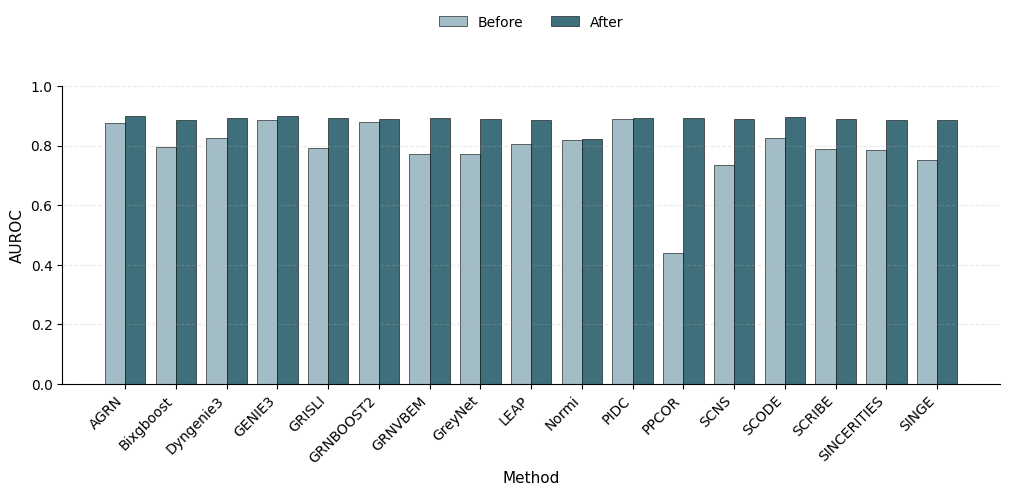

✅ Saved plots:
   - /content/drive/MyDrive/Post_processing_paper_ideas/cross_dataset_summary/plots_avg_across_datasets/git/AvgAcrossDatasets_AUROC_before_vs_after.svg
   - /content/drive/MyDrive/Post_processing_paper_ideas/cross_dataset_summary/plots_avg_across_datasets/git/AvgAcrossDatasets_AUROC_before_vs_after.pdf


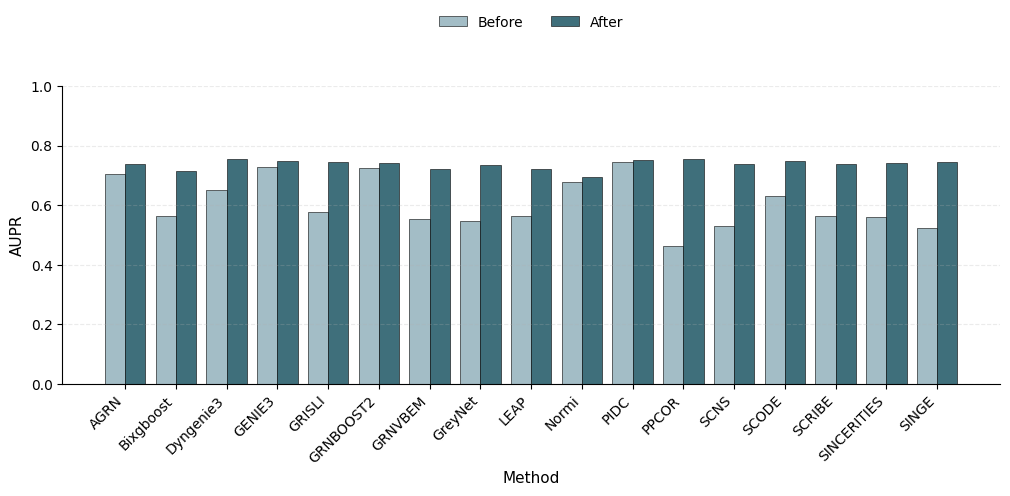

✅ Saved plots:
   - /content/drive/MyDrive/Post_processing_paper_ideas/cross_dataset_summary/plots_avg_across_datasets/git/AvgAcrossDatasets_AUPR_before_vs_after.svg
   - /content/drive/MyDrive/Post_processing_paper_ideas/cross_dataset_summary/plots_avg_across_datasets/git/AvgAcrossDatasets_AUPR_before_vs_after.pdf


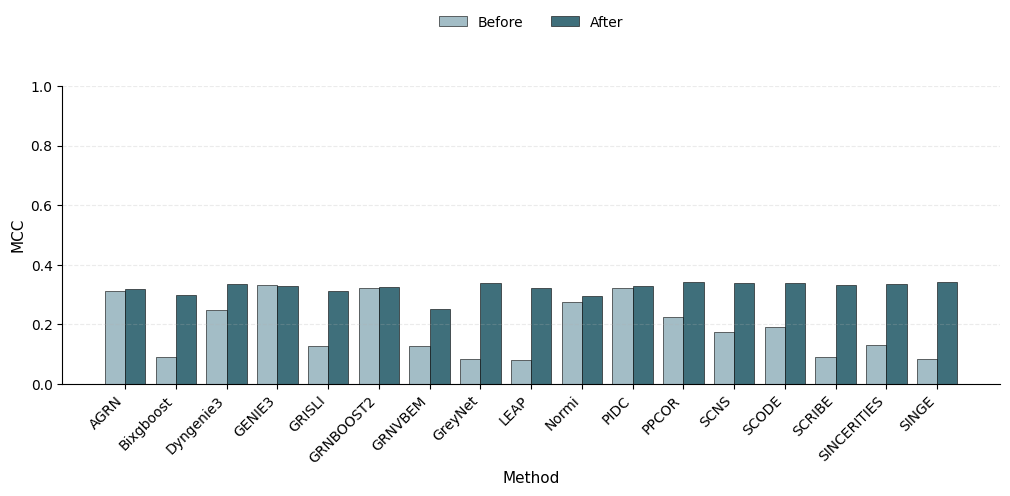

✅ Saved plots:
   - /content/drive/MyDrive/Post_processing_paper_ideas/cross_dataset_summary/plots_avg_across_datasets/git/AvgAcrossDatasets_MCC_before_vs_after.svg
   - /content/drive/MyDrive/Post_processing_paper_ideas/cross_dataset_summary/plots_avg_across_datasets/git/AvgAcrossDatasets_MCC_before_vs_after.pdf


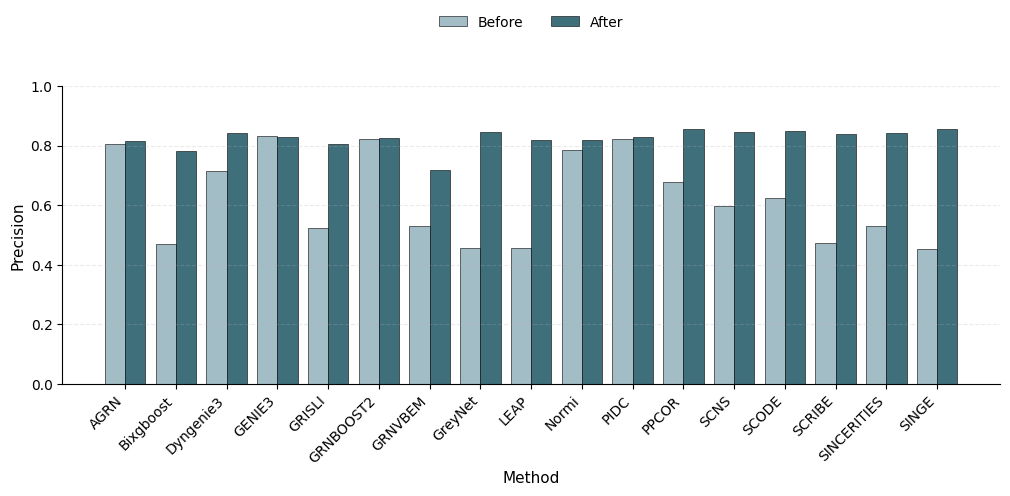

✅ Saved plots:
   - /content/drive/MyDrive/Post_processing_paper_ideas/cross_dataset_summary/plots_avg_across_datasets/git/AvgAcrossDatasets_Precision_before_vs_after.svg
   - /content/drive/MyDrive/Post_processing_paper_ideas/cross_dataset_summary/plots_avg_across_datasets/git/AvgAcrossDatasets_Precision_before_vs_after.pdf


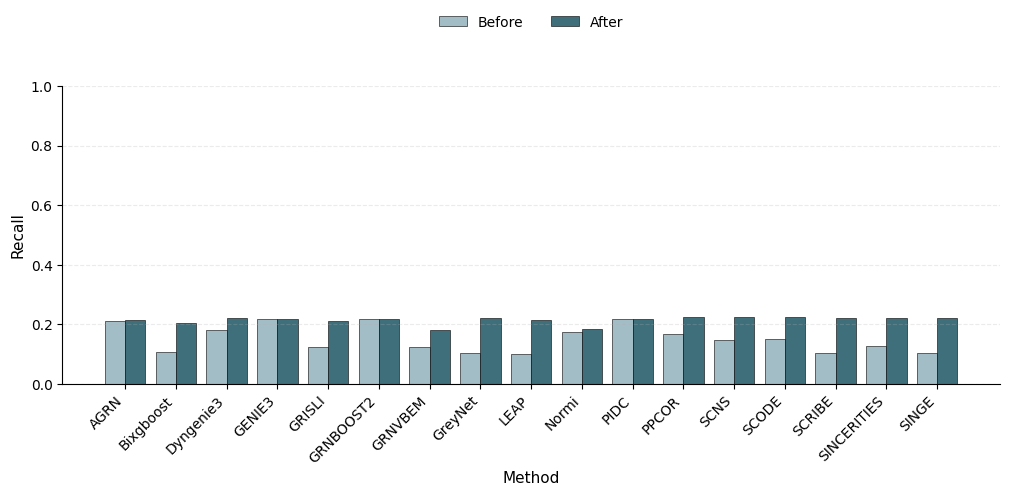

✅ Saved plots:
   - /content/drive/MyDrive/Post_processing_paper_ideas/cross_dataset_summary/plots_avg_across_datasets/git/AvgAcrossDatasets_Recall_before_vs_after.svg
   - /content/drive/MyDrive/Post_processing_paper_ideas/cross_dataset_summary/plots_avg_across_datasets/git/AvgAcrossDatasets_Recall_before_vs_after.pdf


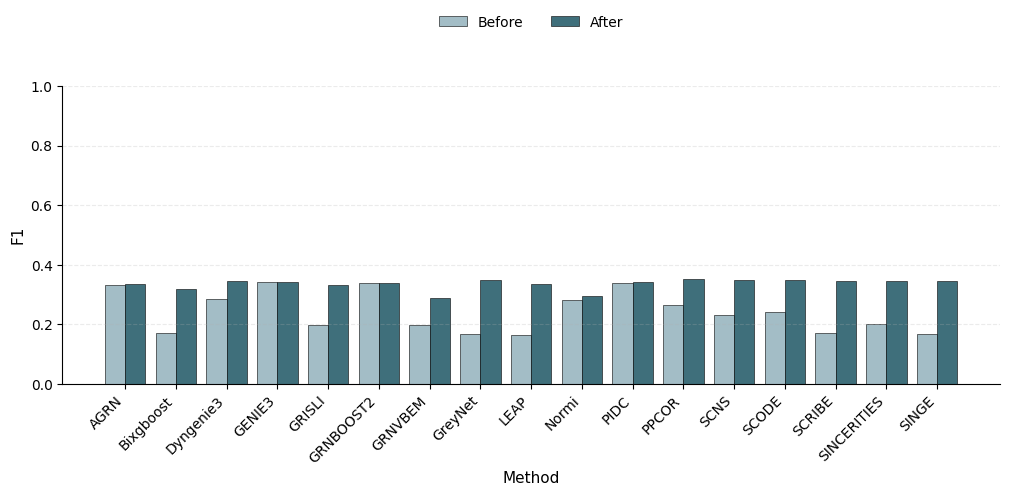

✅ Saved plots:
   - /content/drive/MyDrive/Post_processing_paper_ideas/cross_dataset_summary/plots_avg_across_datasets/git/AvgAcrossDatasets_F1_before_vs_after.svg
   - /content/drive/MyDrive/Post_processing_paper_ideas/cross_dataset_summary/plots_avg_across_datasets/git/AvgAcrossDatasets_F1_before_vs_after.pdf
✅ Saved averaged merged table to: /content/drive/MyDrive/Post_processing_paper_ideas/cross_dataset_summary/plots_avg_across_datasets/git/AveragedMergedTable.csv


In [3]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# ===================== CONFIG ===================== #

dataset_names = ["VSC", "GSD", "HSC", "mCAD"]  # 🔁 put your list here

base_before = Path("/content/drive/MyDrive/Post_processing_paper_ideas")
base_after  = Path(
    "/content/drive/MyDrive/Post_processing_paper_ideas/complete/git/"
    "CLR_ASSOC__mi__v11_ecdf_symmetric"
)

metrics = ["AUROC", "AUPR", "MCC", "Precision", "Recall", "F1"]

# ===================== LOAD + STACK (ALL DATASETS) ===================== #

before_all = []
after_all  = []

for ds in dataset_names:
    before_csv = base_before / ds / "git"/f"AveragedByMethod_{ds}.csv"
    print(f"Loading before_csv: {before_csv}")
    after_csv  = base_after  / ds / f"Shortlisted_{ds}_ALL_results.csv"
    print(f"Loading after_csv: {after_csv}")

    df_before = pd.read_csv(before_csv)[["method"] + metrics].copy()
    df_after  = pd.read_csv(after_csv)[["method"] + metrics].copy()

    df_before[metrics] = df_before[metrics].apply(pd.to_numeric, errors="coerce")
    df_after[metrics]  = df_after[metrics].apply(pd.to_numeric, errors="coerce")

    df_before["method"] = df_before["method"].astype(str).str.strip()
    df_after["method"]  = df_after["method"].astype(str).str.strip()

    df_before.insert(0, "dataset", ds)
    df_after.insert(0, "dataset", ds)

    before_all.append(df_before)
    after_all.append(df_after)

df_before_all = pd.concat(before_all, ignore_index=True)
df_after_all  = pd.concat(after_all,  ignore_index=True)

# ===================== AVERAGE ACROSS DATASETS (PER METHOD) ===================== #

df_before_avg = (
    df_before_all
    .groupby("method", as_index=False)[metrics]
    .mean()
    .rename(columns={m: f"{m}_before" for m in metrics})
)

df_after_avg = (
    df_after_all
    .groupby("method", as_index=False)[metrics]
    .mean()
    .rename(columns={m: f"{m}_after" for m in metrics})
)

df_merged_avg = df_before_avg.merge(df_after_avg, on="method", how="inner")

print("\nAveraged (across datasets) merged table:")
print(df_merged_avg)

# ===================== PLOTS (AVG BEFORE VS AVG AFTER) ===================== #

plots_dir = base_before / "cross_dataset_summary" / "plots_avg_across_datasets"/"git"
plots_dir.mkdir(parents=True, exist_ok=True)

df_merged_avg = df_merged_avg.sort_values("method").reset_index(drop=True)

methods = df_merged_avg["method"].tolist()
x = np.arange(len(methods))
bar_width = 0.4

# Elegant journal colors

# color_before = "#A7BBD0"
# color_after  = "#4B6E8A"


color_before = "#A3BDC6"
color_after  = "#3F6F7B"



for m in metrics:
    before_vals = df_merged_avg[f"{m}_before"].values
    after_vals  = df_merged_avg[f"{m}_after"].values

    fig, ax = plt.subplots(figsize=(max(10, len(methods) * 0.6), 7))

    ax.bar(
        x - bar_width / 2,
        before_vals,
        width=bar_width,
        label="Before",
        color=color_before,
        edgecolor="black",
        linewidth=0.4,
    )
    ax.bar(
        x + bar_width / 2,
        after_vals,
        width=bar_width,
        label="After",
        color=color_after,
        edgecolor="black",
        linewidth=0.4,
    )

     # -------- Titles & labels --------
    # ax.set_title(m, fontsize=14, pad=10)   # slightly tighter title
    ax.set_xlabel("Method", fontsize=11)
    ax.set_ylabel(m, fontsize=11)
    ax.set_ylim(0, 1)

    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=45, ha="right")

    # -------- Legend ABOVE title (no overlap) --------
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.28),  # move legend higher
        ncol=2,
        frameon=False,
        fontsize=10,
    )

    # -------- Aesthetics --------
    ax.grid(axis="y", linestyle="--", alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Reserve vertical space for legend
    plt.tight_layout(rect=[0, 0, 1, 0.82])


    # out_path = plots_dir / f"AvgAcrossDatasets_{m}_before_vs_after.png"
    # plt.savefig(out_path, dpi=300)
    # plt.show()
    # plt.close(fig)

    # print(f"✅ Saved plot: {out_path}")

    out_base = plots_dir / f"AvgAcrossDatasets_{m}_before_vs_after"

    # Save high-quality vector formats
    plt.savefig(out_base.with_suffix(".svg"), format="svg")
    plt.savefig(out_base.with_suffix(".pdf"), format="pdf")

    plt.show()
    plt.close(fig)

    print(f"✅ Saved plots:")
    print(f"   - {out_base.with_suffix('.svg')}")
    print(f"   - {out_base.with_suffix('.pdf')}")



# ===================== OPTIONAL: SAVE THE AVERAGED TABLE USED FOR PLOTS ===================== #

out_csv = plots_dir / f"AveragedMergedTable.csv"
df_merged_avg.to_csv(out_csv, index=False)
print(f"✅ Saved averaged merged table to: {out_csv}")
# /content/drive/MyDrive/Post_processing_paper_ideas/VSC/AveragedByMethod_VSC.csv
#/content/drive/MyDrive/Post_processing_paper_ideas/VSC/AveragedByMethod_VSC.csv
# /content/drive/MyDrive/Post_processing_paper_ideas/complete/CLR_ASSOC__mi__v11_ecdf_symmetric/VSC/Shortlisted_VSC_ALL_results.csv
# /content/drive/MyDrive/Post_processing_paper_ideas/complete/CLR_ASSOC__mi__v11_ecdf_symmetric/VSC/Shortlisted_VSC_ALL_results.csv

In [4]:
import pandas as pd
from pathlib import Path

# ===================== CONFIG ===================== #

dataset_name_list = ["VSC", "HSC", "GSD", "mCAD"]

base_before = Path("/content/drive/MyDrive/Post_processing_paper_ideas")

metrics = ["AUROC", "AUPR", "MCC", "Precision", "Recall", "F1"]

eps = 1e-9  # tolerance for floating-point equality

# ===================== SUMMARY (PER DATASET) ===================== #

for dataset_name in dataset_name_list:
    print("\n" + "=" * 80)
    print(f"Summarizing dataset: {dataset_name}")

    # Load the diff table produced earlier
    diff_csv = base_before / dataset_name / "git"/f"MetricDifferences_AfterMinusBefore_{dataset_name}.csv"
    print(f"Loading diffs from: {diff_csv}")

    df_diff = pd.read_csv(diff_csv)

    summary_rows = []

    for m in metrics:
        diff = df_diff.set_index("method")[f"{m}_diff"]

        improved_methods  = diff[diff >  eps].index.tolist()
        worsened_methods  = diff[diff < -eps].index.tolist()
        unchanged_methods = diff[diff.abs() <= eps].index.tolist()

        summary_rows.append({
            "Metric": m,
            "Improved_count": len(improved_methods),
            "Worsened_count": len(worsened_methods),
            "Unchanged_count": len(unchanged_methods),
            "Improved_methods": ", ".join(improved_methods),
            "Worsened_methods": ", ".join(worsened_methods),
            "Unchanged_methods": ", ".join(unchanged_methods),
        })

    df_summary = pd.DataFrame(summary_rows)

    print("\nSummary:")
    print(df_summary)

    # Save summary
    out_summary_csv = diff_csv.with_name(
        f"MetricDifferences_summary_{dataset_name}.csv"
    )
    df_summary.to_csv(out_summary_csv, index=False)

    print(f"✅ Saved summary to: {out_summary_csv}")



Summarizing dataset: VSC
Loading diffs from: /content/drive/MyDrive/Post_processing_paper_ideas/VSC/git/MetricDifferences_AfterMinusBefore_VSC.csv

Summary:
      Metric  Improved_count  Worsened_count  Unchanged_count  \
0      AUROC              17               0                0   
1       AUPR              17               0                0   
2        MCC              13               0                4   
3  Precision              13               0                4   
4     Recall              13               0                4   
5         F1              13               0                4   

                                    Improved_methods Worsened_methods  \
0  AGRN, Bixgboost, Dyngenie3, GENIE3, GRISLI, GR...                    
1  AGRN, Bixgboost, Dyngenie3, GENIE3, GRISLI, GR...                    
2  Bixgboost, Dyngenie3, GRISLI, GRNVBEM, GreyNet...                    
3  Bixgboost, Dyngenie3, GRISLI, GRNVBEM, GreyNet...                    
4  Bixgboost, Dyngeni

In [5]:
# ===================== AVERAGE IMPROVEMENT ACROSS DATASETS ===================== #
import pandas as pd
from pathlib import Path

# ===================== CONFIG ===================== #

dataset_names = ["VSC", "HSC", "GSD", "mCAD"]  # 🔁 put your 4 dataset names here

base_before = Path("/content/drive/MyDrive/Post_processing_paper_ideas")
base_after  = Path(
    "/content/drive/MyDrive/Post_processing_paper_ideas/complete/git/"
    "CLR_ASSOC__mi__v11_ecdf_symmetric"
)

metrics = ["AUROC", "AUPR", "MCC", "Precision", "Recall", "F1"]

# ===================== HELPERS ===================== #

def compute_diff_for_dataset(dataset_name: str) -> pd.DataFrame:
    """Return per-method per-metric diffs (after - before) for one dataset."""
    before_csv = base_before / dataset_name / "git"/f"AveragedByMethod_{dataset_name}.csv"
    after_csv  = base_after  / dataset_name / f"Shortlisted_{dataset_name}_ALL_results.csv"

    df_before = pd.read_csv(before_csv)
    df_after  = pd.read_csv(after_csv)

    df_before = df_before[["method"] + metrics].copy()
    df_after  = df_after[["method"] + metrics].copy()

    df_before[metrics] = df_before[metrics].apply(pd.to_numeric, errors="coerce")
    df_after[metrics]  = df_after[metrics].apply(pd.to_numeric, errors="coerce")

    df_before["method"] = df_before["method"].astype(str).str.strip()
    df_after["method"]  = df_after["method"].astype(str).str.strip()

    df_merged = df_before.merge(
        df_after,
        on="method",
        suffixes=("_before", "_after"),
        how="inner"
    )

    # Compute diffs
    for m in metrics:
        df_merged[f"{m}_diff"] = df_merged[f"{m}_after"] - df_merged[f"{m}_before"]

    df_diff = df_merged[["method"] + [f"{m}_diff" for m in metrics]].copy()
    df_diff.insert(0, "dataset", dataset_name)
    return df_diff

# ===================== RUN ACROSS DATASETS ===================== #

all_diffs = []
for ds in dataset_names:
    df_ds = compute_diff_for_dataset(ds)
    all_diffs.append(df_ds)

df_all = pd.concat(all_diffs, ignore_index=True)

print("\nAll dataset diffs (after - before) stacked:")
print(df_all)

# ===================== AVERAGE IMPROVEMENT ACROSS DATASETS ===================== #
# This averages diffs over datasets for each METHOD (and each metric).
df_avg_by_method = (
    df_all
    .groupby("method", as_index=False)[[f"{m}_diff" for m in metrics]]
    .mean()
)

print("\nAverage improvement across datasets (per method):")
print(df_avg_by_method)

# Overall average improvement across ALL datasets and ALL methods (per metric)
df_overall_avg = (
    df_all[[f"{m}_diff" for m in metrics]]
    .mean()
    .to_frame(name="overall_avg_diff")
    .reset_index()
    .rename(columns={"index": "metric"})
)

print("\nOverall average improvement (across all datasets & methods):")
print(df_overall_avg)

# ===================== SAVE OUTPUTS ===================== #

out_dir = base_before / "cross_dataset_summary"
out_dir.mkdir(parents=True, exist_ok=True)

df_all.to_csv(out_dir / "AllDatasets_MethodMetric_Differences.csv", index=False)
df_avg_by_method.to_csv(out_dir / "AvgImprovementAcrossDatasets_ByMethod.csv", index=False)
df_overall_avg.to_csv(out_dir / "OverallAvgImprovementAcrossDatasets_ByMetric.csv", index=False)

print(f"\n✅ Saved outputs to: {out_dir}")
# ===================== AFTER-ONLY RAW VALUES ACROSS DATASETS ===================== #

def load_after_for_dataset(dataset_name: str) -> pd.DataFrame:
    """Return AFTER raw metrics for one dataset."""
    after_csv = base_after / dataset_name / f"Shortlisted_{dataset_name}_ALL_results.csv"

    df_after = pd.read_csv(after_csv)
    df_after = df_after[["method"] + metrics].copy()

    df_after[metrics] = df_after[metrics].apply(pd.to_numeric, errors="coerce")
    df_after["method"] = df_after["method"].astype(str).str.strip()

    df_after.insert(0, "dataset", dataset_name)
    return df_after


# Load AFTER values for all datasets
after_all = []
for ds in dataset_names:
    df_after_ds = load_after_for_dataset(ds)
    after_all.append(df_after_ds)

df_after_all = pd.concat(after_all, ignore_index=True)

print("\nAFTER raw values stacked across datasets:")
print(df_after_all)

# ===================== AVERAGE AFTER VALUES ACROSS DATASETS ===================== #

df_after_avg_by_method = (
    df_after_all
    .groupby("method", as_index=False)[metrics]
    .mean()
)

print("\nAverage AFTER metrics across datasets (per method):")
print(df_after_avg_by_method)

# ===================== SAVE ===================== #

df_after_avg_by_method.to_csv(
    out_dir / "AvgAfterMetricsAcrossDatasets_ByMethod.csv",
    index=False
)

print(
    f"✅ Saved AFTER-only averaged metrics to: "
    f"{out_dir / 'AvgAfterMetricsAcrossDatasets_ByMethod.csv'}"
)



All dataset diffs (after - before) stacked:
   dataset       method  AUROC_diff  AUPR_diff  MCC_diff  Precision_diff  \
0      VSC         AGRN    0.056061   0.070494  0.000000            0.00   
1      VSC    Bixgboost    0.189394   0.335291  0.405556            0.60   
2      VSC    Dyngenie3    0.132576   0.237928  0.304167            0.45   
3      VSC       GENIE3    0.038636   0.055538  0.000000            0.00   
4      VSC       GRISLI    0.188258   0.329335  0.371760            0.55   
..     ...          ...         ...        ...       ...             ...   
63    mCAD         SCNS    0.000000   0.000000  0.000000            0.00   
64    mCAD        SCODE    0.000000   0.000000  0.000000            0.00   
65    mCAD       SCRIBE    0.000000   0.000000  0.000000            0.00   
66    mCAD  SINCERITIES    0.000000   0.000000  0.000000            0.00   
67    mCAD        SINGE    0.000000   0.000000  0.000000            0.00   

    Recall_diff  F1_diff  
0      0.000000